In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-04 17:36:51.937726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 17:36:51.944348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 17:36:51.944801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-04 17:36:52.223679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 17:36:52.224479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 17:36:52.224876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 17:36:52.225187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[0.        , 1.8668884 , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.08007274, 0.        , 0.        ],
         ...,
         [0.5929008 , 0.        , 0.750586  ],
         [0.        , 0.        , 0.        ],
         [0.        , 2.6290824 , 0.        ]],

        [[2.4208634 , 3.7178092 , 0.49351725],
         [1.6267399 , 0.        , 2.5619502 ],
         [1.2313182 , 0.        , 0.        ],
         ...,
         [1.7407758 , 0.        , 0.        ],
         [0.12965159, 0.        , 0.        ],
         [0.5787131 , 0.        , 3.2274294 ]],

        [[0.6233523 , 0.        , 0.        ],
         [1.079587  , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 2.1142814 , 0.        ],
         [0.88611305, 0.8276486 , 0.37499532],
         [0.        , 0.2629155 , 0.        ]],

        ...,

        [[3.203559  , 0.        , 

In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.        , 1.8668884 , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.08007274, 0.        , 0.        ],
          ...,
          [0.5929008 , 0.        , 0.750586  ],
          [0.        , 0.        , 0.        ],
          [0.        , 2.6290824 , 0.        ]],
 
         [[2.4208634 , 3.7178092 , 0.49351725],
          [1.6267399 , 0.        , 2.5619502 ],
          [1.2313182 , 0.        , 0.        ],
          ...,
          [1.7407758 , 0.        , 0.        ],
          [0.12965159, 0.        , 0.        ],
          [0.5787131 , 0.        , 3.2274294 ]],
 
         [[0.6233523 , 0.        , 0.        ],
          [1.079587  , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 2.1142814 , 0.        ],
          [0.88611305, 0.8276486 , 0.37499532],
          [0.        , 0.2629155 , 0.        ]],
 
         ...,


<IPython.core.display.Javascript object>


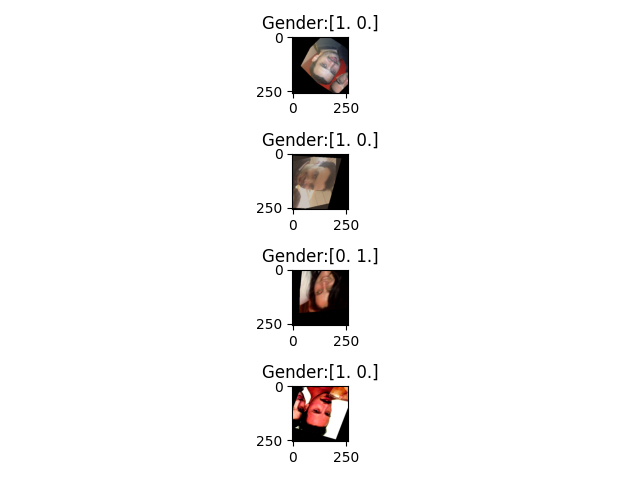

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 7, strides=(4,4), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(128, 5, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(256, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv5'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(256, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_14')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 128

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 128)          1009600     ['tf.math.subtract[0][0]']   

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_14"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 2500, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-04 17:36:55.989615: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-04 17:36:55.989636: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-04 17:36:55.989655: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-04 17:36:56.071216: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-04 17:36:56.072554: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-04 17:36:56.708423: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


   9/3528 [..............................] - ETA: 22s - loss: 7017.5840 - gender_out_loss: 0.6857 - tf.math.multiply_1_loss: 5303.2388 - gender_out_accuracy: 0.6111    

2022-11-04 17:36:57.458558: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 15s 4ms/step - loss: 7726.5303 - gender_out_loss: 0.6943 - tf.math.multiply_1_loss: 5990.7886 - gender_out_accuracy: 0.4774
Epoch 1/300
   1/1000 [..............................] - ETA: 14:43 - loss: 7930.9102 - gender_out_loss: 0.6966 - tf.math.multiply_1_loss: 6189.3906 - gender_out_accuracy: 0.2500

2022-11-04 17:37:11.950519: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-04 17:37:11.950683: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  10/1000 [..............................] - ETA: 1:15 - loss: 9473.3643 - gender_out_loss: 0.6883 - tf.math.multiply_1_loss: 7752.5483 - gender_out_accuracy: 0.4500

2022-11-04 17:37:12.445219: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-04 17:37:12.446124: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-04 17:37:12.477937: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3143 callback api events and 3102 activity events. 
2022-11-04 17:37:12.503331: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-04 17:37:12.534416: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_14/log_0/plugins/profile/2022_11_04_17_37_12

2022-11-04 17:37:12.575973: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_14/log_0/plugins/profile/2022_11_04_17_37_12/rachanon-pc1.trace.json.gz
2022-11-04 17:37:12.613403: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log

1000/1000 [==============================] - 22s 21ms/step - loss: 4395.5913 - gender_out_loss: 0.6743 - tf.math.multiply_1_loss: 2709.8013 - gender_out_accuracy: 0.5905 - val_loss: 3751.8577 - val_gender_out_loss: 0.6842 - val_tf.math.multiply_1_loss: 2041.2694 - val_gender_out_accuracy: 0.5631
Epoch 2/300
1000/1000 [==============================] - 20s 20ms/step - loss: 3207.2720 - gender_out_loss: 0.6560 - tf.math.multiply_1_loss: 1567.1910 - gender_out_accuracy: 0.6198 - val_loss: 3296.1343 - val_gender_out_loss: 0.6843 - val_tf.math.multiply_1_loss: 1585.2996 - val_gender_out_accuracy: 0.5578
Epoch 3/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2962.2209 - gender_out_loss: 0.6468 - tf.math.multiply_1_loss: 1345.1995 - gender_out_accuracy: 0.5995 - val_loss: 3182.5864 - val_gender_out_loss: 0.6826 - val_tf.math.multiply_1_loss: 1476.0540 - val_gender_out_accuracy: 0.5780
Epoch 4/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2893.9

Epoch 28/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2464.2407 - gender_out_loss: 0.6644 - tf.math.multiply_1_loss: 803.1707 - gender_out_accuracy: 0.5955 - val_loss: 2744.5549 - val_gender_out_loss: 0.7043 - val_tf.math.multiply_1_loss: 983.8156 - val_gender_out_accuracy: 0.5400
Epoch 29/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2459.8838 - gender_out_loss: 0.6640 - tf.math.multiply_1_loss: 799.9720 - gender_out_accuracy: 0.6043 - val_loss: 2624.2151 - val_gender_out_loss: 0.6723 - val_tf.math.multiply_1_loss: 943.5142 - val_gender_out_accuracy: 0.5765
Epoch 30/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2409.9338 - gender_out_loss: 0.6446 - tf.math.multiply_1_loss: 798.4376 - gender_out_accuracy: 0.6298 - val_loss: 2822.6882 - val_gender_out_loss: 0.7425 - val_tf.math.multiply_1_loss: 966.3574 - val_gender_out_accuracy: 0.5325
Epoch 31/300
1000/1000 [==============================] - 21s 21ms/step - lo

Epoch 55/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2263.3162 - gender_out_loss: 0.6389 - tf.math.multiply_1_loss: 666.1769 - gender_out_accuracy: 0.6423 - val_loss: 2411.9646 - val_gender_out_loss: 0.6593 - val_tf.math.multiply_1_loss: 763.7382 - val_gender_out_accuracy: 0.6103
Epoch 56/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2222.8430 - gender_out_loss: 0.6278 - tf.math.multiply_1_loss: 653.3601 - gender_out_accuracy: 0.6367 - val_loss: 2443.0339 - val_gender_out_loss: 0.6635 - val_tf.math.multiply_1_loss: 784.2164 - val_gender_out_accuracy: 0.5875
Epoch 57/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2270.4116 - gender_out_loss: 0.6438 - tf.math.multiply_1_loss: 660.9250 - gender_out_accuracy: 0.6320 - val_loss: 2435.3335 - val_gender_out_loss: 0.6625 - val_tf.math.multiply_1_loss: 778.9884 - val_gender_out_accuracy: 0.6003
Epoch 58/300
1000/1000 [==============================] - 21s 21ms/step - lo

Epoch 82/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2224.5959 - gender_out_loss: 0.6450 - tf.math.multiply_1_loss: 612.0376 - gender_out_accuracy: 0.6263 - val_loss: 2327.7812 - val_gender_out_loss: 0.6450 - val_tf.math.multiply_1_loss: 715.1874 - val_gender_out_accuracy: 0.6175
Epoch 83/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2135.5891 - gender_out_loss: 0.6097 - tf.math.multiply_1_loss: 611.4277 - gender_out_accuracy: 0.6727 - val_loss: 2763.3494 - val_gender_out_loss: 0.8019 - val_tf.math.multiply_1_loss: 758.4915 - val_gender_out_accuracy: 0.5265
Epoch 84/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2141.8562 - gender_out_loss: 0.6114 - tf.math.multiply_1_loss: 613.2474 - gender_out_accuracy: 0.6612 - val_loss: 2441.0791 - val_gender_out_loss: 0.6511 - val_tf.math.multiply_1_loss: 813.4356 - val_gender_out_accuracy: 0.6214
Epoch 85/300
1000/1000 [==============================] - 21s 21ms/step - lo

Epoch 109/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2118.1843 - gender_out_loss: 0.6005 - tf.math.multiply_1_loss: 616.9890 - gender_out_accuracy: 0.6593 - val_loss: 2276.8818 - val_gender_out_loss: 0.6277 - val_tf.math.multiply_1_loss: 707.7348 - val_gender_out_accuracy: 0.6648
Epoch 110/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2133.1411 - gender_out_loss: 0.6157 - tf.math.multiply_1_loss: 593.8341 - gender_out_accuracy: 0.6620 - val_loss: 2300.8596 - val_gender_out_loss: 0.6352 - val_tf.math.multiply_1_loss: 712.7408 - val_gender_out_accuracy: 0.6326
Epoch 111/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2091.1360 - gender_out_loss: 0.5959 - tf.math.multiply_1_loss: 601.4991 - gender_out_accuracy: 0.6795 - val_loss: 2333.9336 - val_gender_out_loss: 0.6395 - val_tf.math.multiply_1_loss: 735.1827 - val_gender_out_accuracy: 0.6421
Epoch 112/300
1000/1000 [==============================] - 21s 21ms/step 

1000/1000 [==============================] - 20s 20ms/step - loss: 2101.3311 - gender_out_loss: 0.6034 - tf.math.multiply_1_loss: 592.9288 - gender_out_accuracy: 0.6755 - val_loss: 2213.8616 - val_gender_out_loss: 0.5993 - val_tf.math.multiply_1_loss: 715.5414 - val_gender_out_accuracy: 0.6742
Epoch 136/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2013.4535 - gender_out_loss: 0.5678 - tf.math.multiply_1_loss: 594.0419 - gender_out_accuracy: 0.7075 - val_loss: 2198.8386 - val_gender_out_loss: 0.6003 - val_tf.math.multiply_1_loss: 698.1836 - val_gender_out_accuracy: 0.6695
Epoch 137/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2026.3844 - gender_out_loss: 0.5759 - tf.math.multiply_1_loss: 586.5171 - gender_out_accuracy: 0.6973 - val_loss: 2206.1653 - val_gender_out_loss: 0.5908 - val_tf.math.multiply_1_loss: 729.2726 - val_gender_out_accuracy: 0.6904
Epoch 138/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2101.4

1000/1000 [==============================] - 21s 21ms/step - loss: 1980.2075 - gender_out_loss: 0.5684 - tf.math.multiply_1_loss: 559.2736 - gender_out_accuracy: 0.7005 - val_loss: 2733.5938 - val_gender_out_loss: 0.8061 - val_tf.math.multiply_1_loss: 718.4165 - val_gender_out_accuracy: 0.5725
Epoch 162/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2050.6792 - gender_out_loss: 0.5810 - tf.math.multiply_1_loss: 598.1703 - gender_out_accuracy: 0.6915 - val_loss: 2259.3740 - val_gender_out_loss: 0.6216 - val_tf.math.multiply_1_loss: 705.3809 - val_gender_out_accuracy: 0.6284
Epoch 163/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2033.8662 - gender_out_loss: 0.5833 - tf.math.multiply_1_loss: 575.7140 - gender_out_accuracy: 0.6965 - val_loss: 2203.4670 - val_gender_out_loss: 0.5936 - val_tf.math.multiply_1_loss: 719.4503 - val_gender_out_accuracy: 0.6802
Epoch 164/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1946.7

1000/1000 [==============================] - 21s 21ms/step - loss: 2062.5969 - gender_out_loss: 0.5887 - tf.math.multiply_1_loss: 590.7229 - gender_out_accuracy: 0.6862 - val_loss: 2089.9382 - val_gender_out_loss: 0.5538 - val_tf.math.multiply_1_loss: 705.5488 - val_gender_out_accuracy: 0.7177
Epoch 188/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1938.3834 - gender_out_loss: 0.5541 - tf.math.multiply_1_loss: 553.1020 - gender_out_accuracy: 0.7185 - val_loss: 2407.5066 - val_gender_out_loss: 0.6768 - val_tf.math.multiply_1_loss: 715.6150 - val_gender_out_accuracy: 0.6620
Epoch 189/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1937.6793 - gender_out_loss: 0.5425 - tf.math.multiply_1_loss: 581.3331 - gender_out_accuracy: 0.7237 - val_loss: 2090.7715 - val_gender_out_loss: 0.5593 - val_tf.math.multiply_1_loss: 692.5499 - val_gender_out_accuracy: 0.7248
Epoch 190/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1929.9

1000/1000 [==============================] - 21s 21ms/step - loss: 1826.6044 - gender_out_loss: 0.5101 - tf.math.multiply_1_loss: 551.4253 - gender_out_accuracy: 0.7500 - val_loss: 2002.6326 - val_gender_out_loss: 0.5178 - val_tf.math.multiply_1_loss: 708.0939 - val_gender_out_accuracy: 0.7470
Epoch 214/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1853.2875 - gender_out_loss: 0.5241 - tf.math.multiply_1_loss: 543.0510 - gender_out_accuracy: 0.7297 - val_loss: 2287.1714 - val_gender_out_loss: 0.6384 - val_tf.math.multiply_1_loss: 691.1000 - val_gender_out_accuracy: 0.6672
Epoch 215/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1994.1123 - gender_out_loss: 0.5611 - tf.math.multiply_1_loss: 591.4362 - gender_out_accuracy: 0.7135 - val_loss: 2169.1587 - val_gender_out_loss: 0.5939 - val_tf.math.multiply_1_loss: 684.3173 - val_gender_out_accuracy: 0.6814
Epoch 216/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1878.4

1000/1000 [==============================] - 21s 21ms/step - loss: 1835.0724 - gender_out_loss: 0.5138 - tf.math.multiply_1_loss: 550.5909 - gender_out_accuracy: 0.7455 - val_loss: 1992.0939 - val_gender_out_loss: 0.5202 - val_tf.math.multiply_1_loss: 691.5038 - val_gender_out_accuracy: 0.7319
Epoch 240/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1909.3223 - gender_out_loss: 0.5384 - tf.math.multiply_1_loss: 563.4307 - gender_out_accuracy: 0.7360 - val_loss: 2108.6943 - val_gender_out_loss: 0.5578 - val_tf.math.multiply_1_loss: 714.3105 - val_gender_out_accuracy: 0.7194
Epoch 241/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1807.5887 - gender_out_loss: 0.5011 - tf.math.multiply_1_loss: 554.7849 - gender_out_accuracy: 0.7588 - val_loss: 2246.9827 - val_gender_out_loss: 0.6193 - val_tf.math.multiply_1_loss: 698.6983 - val_gender_out_accuracy: 0.6927
Epoch 242/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1852.2

1000/1000 [==============================] - 20s 20ms/step - loss: 1815.4670 - gender_out_loss: 0.4998 - tf.math.multiply_1_loss: 565.9283 - gender_out_accuracy: 0.7545 - val_loss: 2011.4094 - val_gender_out_loss: 0.5223 - val_tf.math.multiply_1_loss: 705.6071 - val_gender_out_accuracy: 0.7413
Epoch 266/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1724.4890 - gender_out_loss: 0.4743 - tf.math.multiply_1_loss: 538.8591 - gender_out_accuracy: 0.7665 - val_loss: 2049.2539 - val_gender_out_loss: 0.5382 - val_tf.math.multiply_1_loss: 703.6696 - val_gender_out_accuracy: 0.7308
Epoch 267/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1773.5529 - gender_out_loss: 0.4956 - tf.math.multiply_1_loss: 534.5776 - gender_out_accuracy: 0.7570 - val_loss: 2040.1567 - val_gender_out_loss: 0.5301 - val_tf.math.multiply_1_loss: 714.9296 - val_gender_out_accuracy: 0.7401
Epoch 268/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1864.0

1000/1000 [==============================] - 20s 20ms/step - loss: 1713.6454 - gender_out_loss: 0.4599 - tf.math.multiply_1_loss: 563.9164 - gender_out_accuracy: 0.7803 - val_loss: 2020.4766 - val_gender_out_loss: 0.5375 - val_tf.math.multiply_1_loss: 676.6858 - val_gender_out_accuracy: 0.7267
Epoch 292/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1785.8477 - gender_out_loss: 0.4949 - tf.math.multiply_1_loss: 548.6974 - gender_out_accuracy: 0.7523 - val_loss: 1916.3447 - val_gender_out_loss: 0.4962 - val_tf.math.multiply_1_loss: 675.8548 - val_gender_out_accuracy: 0.7653
Epoch 293/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1779.4883 - gender_out_loss: 0.4892 - tf.math.multiply_1_loss: 556.5112 - gender_out_accuracy: 0.7645 - val_loss: 1958.1840 - val_gender_out_loss: 0.5048 - val_tf.math.multiply_1_loss: 696.3012 - val_gender_out_accuracy: 0.7522
Epoch 294/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1731.6

In [47]:
out = model(x)

In [48]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[4.64563072e-02, 2.72597373e-02, 3.96166742e-02],
          [8.18476081e-03, 1.11030042e-02, 8.31395388e-03],
          [1.73270702e-03, 2.29507685e-03, 7.18161464e-03],
          ...,
          [6.11440420e-01, 5.77333450e-01, 7.71791816e-01],
          [4.04693484e-01, 5.24751842e-01, 5.94234943e-01],
          [3.93187702e-01, 4.11639512e-01, 3.87024432e-01]],
 
         [[1.23189390e-02, 1.78134441e-02, 8.83832574e-03],
          [2.03669071e-03, 3.67060304e-03, 4.27097082e-03],
          [1.40592456e-03, 3.15383077e-03, 4.94733453e-03],
          ...,
          [7.03729868e-01, 1.00467372e+00, 7.34029412e-01],
          [5.80935597e-01, 6.30477369e-01, 5.25147021e-01],
          [3.71734053e-01, 4.33549136e-01, 3.52879465e-01]],
 
         [[9.59828496e-03, 9.20310616e-03, 5.38811088e-03],
          [3.55660915e-03, 2.34067440e-03, 1.32232904e-03],
          [2.75865197e-03, 2.68265605e-03, 2.78905034e-0

<IPython.core.display.Javascript object>


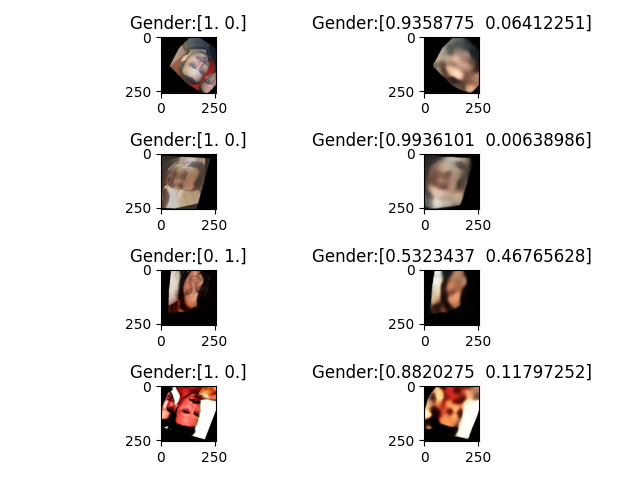

In [49]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()

In [50]:
for xTest, yTest in folds[0][1].take(1):
    pass

In [51]:
outTest = model(xTest)

In [52]:
outTest

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[7.43034959e-01, 4.25326377e-01, 4.46255654e-01],
          [3.94601226e-01, 4.06722575e-01, 2.76488364e-01],
          [1.26632005e-01, 1.24268532e-01, 2.93199867e-01],
          ...,
          [3.96417528e-01, 3.12563628e-01, 4.57472652e-01],
          [1.89169049e-01, 2.25229114e-01, 2.84285545e-01],
          [1.57965124e-01, 1.31852925e-01, 1.18660033e-01]],
 
         [[3.78224105e-01, 3.68777812e-01, 1.48944408e-01],
          [1.77252889e-01, 2.50011384e-01, 2.29120106e-01],
          [1.23417377e-01, 2.27053016e-01, 2.53241211e-01],
          ...,
          [3.05435210e-01, 4.66660559e-01, 3.48160118e-01],
          [2.11344659e-01, 2.56296247e-01, 1.68566555e-01],
          [1.22703016e-01, 1.23265386e-01, 9.13470984e-02]],
 
         [[3.41244489e-01, 3.00031900e-01, 1.61681324e-01],
          [2.93982625e-01, 2.39265561e-01, 1.03681237e-01],
          [2.27334201e-01, 3.17769349e-01, 2.91185975e-0

<IPython.core.display.Javascript object>


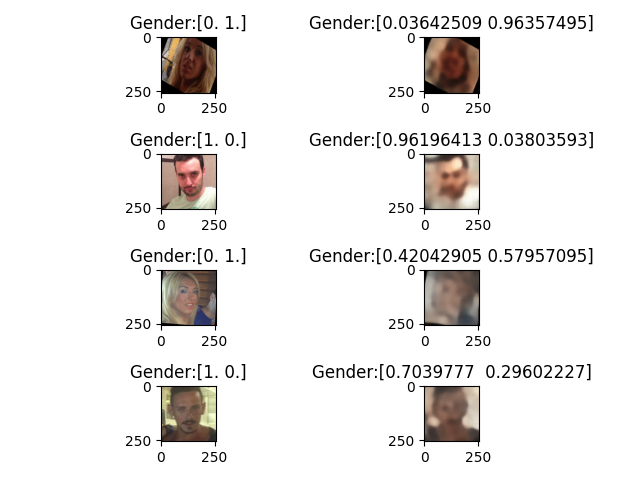

In [53]:
fig3, ax3 = plt.subplots(nrows=VAL_BATCH_SIZE, ncols=2)

if(VAL_BATCH_SIZE is None or VAL_BATCH_SIZE == 1):
    ax3[0].imshow(x/255)
    ax3[0].set_title(yTest['gender'])
    
    ax3[1].imshow(out['recon']/255)
    ax3[1].set_title(outTest['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax3[i, 0].imshow(xTest[i]/255)
        ax3[i, 0].set_title(f"Gender:{yTest['gender'][i]}")
        
        ax3[i, 1].imshow(outTest['recon'][i]/255)
        ax3[i, 1].set_title(f"Gender:{outTest['gender'][i]}")
        
plt.tight_layout()